### Analysis of White masks in the steel sheets

In [73]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap
import warnings

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from scipy.stats import mannwhitneyu
### Fast import of Captum Algorithm
from captum.attr import (
    GradientShap, DeepLift, DeepLiftShap, IntegratedGradients, LayerConductance, 
    NeuronConductance, NoiseTunnel, GuidedGradCam, visualization)

def visualize_gradcam(n, module, out_type='id', normalizer=False, color_normalizer=True, return_output = False):
    ### 7.3.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    if y_val[n] > 0:
        mask = M_val[n].reshape(*params['size'])
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n]-1)]
    ax.imshow(img)
    y_score_tmp = nn.Softmax(dim=1)(net(X_val[n].unsqueeze(0).to(device))).reshape(1, -1)
    
    ax.set_title('Input image')

    ### 7.3.b) Initialize GradCam passing the network and the last Convolutional Layer and the results tensor
    grad_cam = c_explainers.GradCam(net, module, device)
    results = torch.Tensor([])    

    ### 7.3.c) Compute GradCam for both target (No Defect/Defect)
    for i in range(n_classes):
        ### 7.3.c.i)  Compute Grad Cam with out_type 'id'. It means that no ReLU operation is done on the GradCam output
        _, original_out = grad_cam(X_val[n], i, out_type=out_type, interpolation_mode = cv2.INTER_LANCZOS4,  additional_out = True)
        ### 7.3.c.ii) Save the results
        grad_cam_output = cv2.resize(original_out.numpy(), (25*16, 4*16))
        results = torch.cat([results, torch.tensor(grad_cam_output).reshape(1, *list(grad_cam_output.shape))])

    ### 7.3.d) Normalize the results     
    if normalizer:
        gc_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))
        gc_results = gc_results*2 - 1
    else:
        gc_results = results

    ### 7.3.e) Show GradCam outcomes
    fig = plt.figure(figsize = (16.8, 3.0*n_classes))                            ### Set figure                   
    for j in range(n_classes):          
        ax = fig.add_subplot(n_classes, 1, j+1)                                  ### Addsubplot to figure
        img_input = gc_results[j].numpy()                                        ### Get normalized GradCam output
        img_input[0, 0] = 1
        img_input[0, 1] = -1
        ### 7.3.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 7.3.e.ii) Plot GradCam outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('GradCAM: probability of {} = {:.3f}'.format(class_labels[j], float(y_score_tmp[0, j])))
    plt.show()
    return gc_results

### Load data

In [2]:
n_classes = 5
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}
params = c_utils.get_default_params()
device = torch.device('cuda')
#warnings.filterwarnings("ignore")

In [3]:
MODEL_PATH = '../model/OfficialMultiModels/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [4]:
white_index = [13, 17, 22, 29, 34, 35, 40, 60, 70, 78,
               82, 87, 99, 102, 115, 131, 134, 145, 148, 160,
               185, 193, 214, 221, 229, 235, 251, 256, 268, 274,
               278, 293, 299, 309, 310, 319, 323, 336, 357, 359,
               360, 365, 371, 379, 393, 394, 397, 405, 412, 416]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


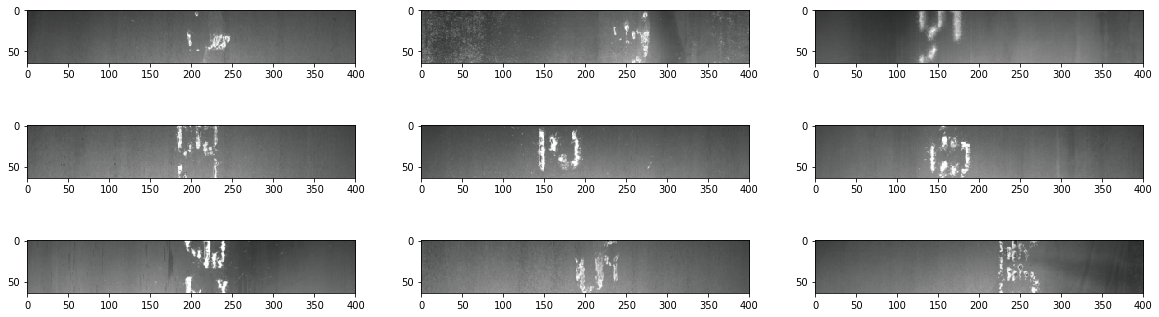

In [63]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
X_masked = X_val[white_index]

fig, ax = plt.subplots(3, 3, figsize=(20, 6))
start = 0
for i in range(start, start+9):
    img = np.transpose(X_masked[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    #ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### Model

In [7]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 2

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), 
                                                  f1_score(y_true, y_pred, average='weighted')))

100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:16<00:00, 73.56it/s]

Accuracy: 0.9213	F1 Score: 0.9237


### Analysis

In [8]:
n = 0
X_no_masked = torch.Tensor([])
list_no_white_img = []
for i in range(X_val.shape[0]):
    if y_val[i] == 0 and i not in white_index:
        X_no_masked = torch.cat([X_no_masked, X_val[i].unsqueeze(0)])
        list_no_white_img.append(i)
        n += 1
    if n==50:
        break

In [9]:
print('Number of missclassfied example for the group with no white stains: {}'.format(
      y_pred[list_no_white_img][y_pred[list_no_white_img] != 0].shape[0]))
print('Number of missclassfied example for the group with white stains: {}'.format(
      y_pred[white_index][y_pred[white_index] != 0].shape[0]))

Number of missclassfied example for the group with no white stains: 5
Number of missclassfied example for the group with white stains: 0


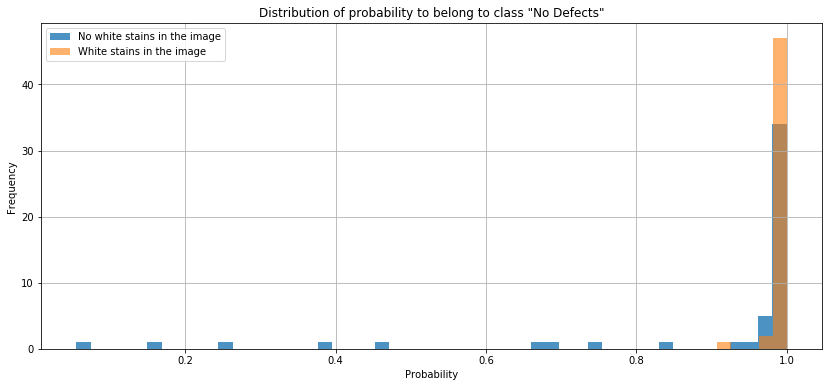

In [17]:
with torch.no_grad():
    net.eval()
    out_no_masked = net(X_no_masked.to(device))
    no_masked_pred = torch.argmax(out_no_masked, axis=1).cpu().numpy()
    no_masked_prob = nn.Softmax(dim=1)(out_no_masked)[:, 0].cpu().numpy()
    out_masked = net(X_masked.to(device))
    masked_pred = torch.argmax(out_masked, axis=1).cpu().numpy()
    masked_prob = nn.Softmax(dim=1)(out_masked)[:, 0].cpu().numpy()
plt.figure(figsize=(14, 6))
plt.title('Distribution of probability to belong to class "No Defects"')

plt.hist(no_masked_prob, bins=50, label='No white stains in the image', alpha=0.8)
plt.hist(masked_prob, bins=5, label='White stains in the image', alpha=0.6)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

In [11]:
u, p = mannwhitneyu(no_masked_prob, masked_pred, alternative='greater')
print('p-value of Mann-Whitney U test with alternative hypotesis "greater": {}'.format(p))

p-value of Mann-Whitney U test with alternative hypotesis "greater": 1.6385837183460314e-20


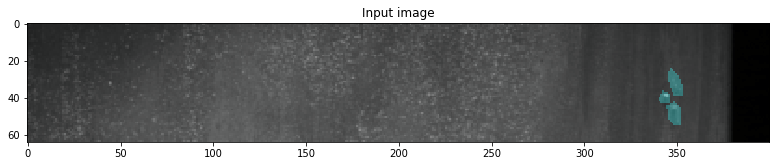

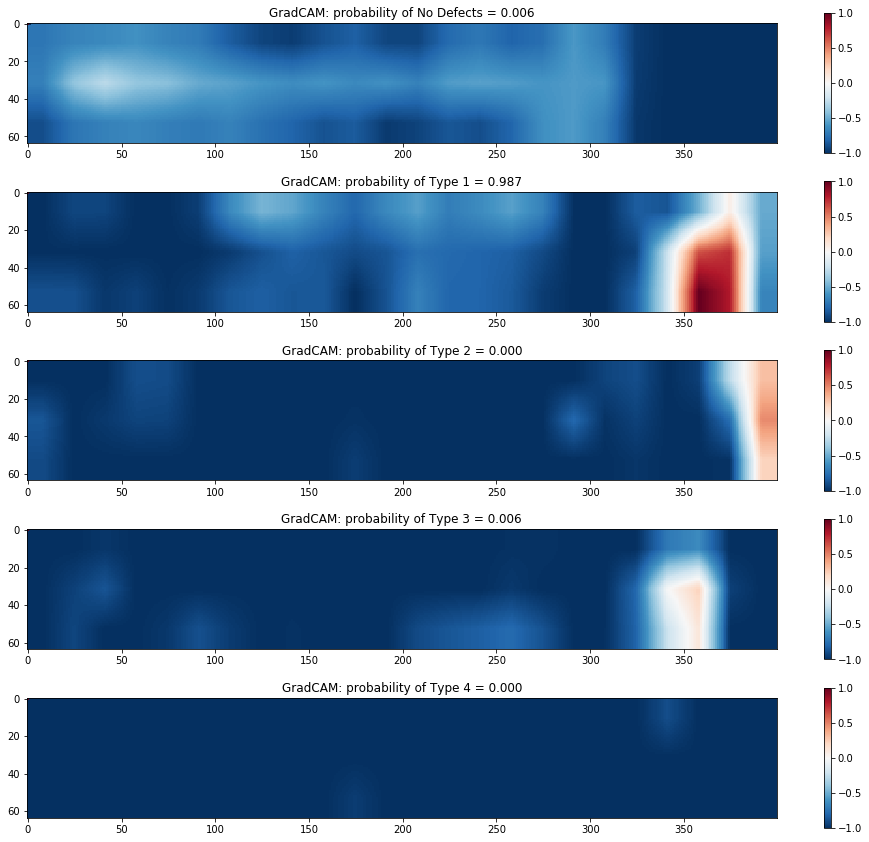

In [111]:
n = 20
copied = False
res = visualize_gradcam(n, module = net.classifier[1], out_type='relu', normalizer=True, color_normalizer=False, return_output=True)

In [101]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)

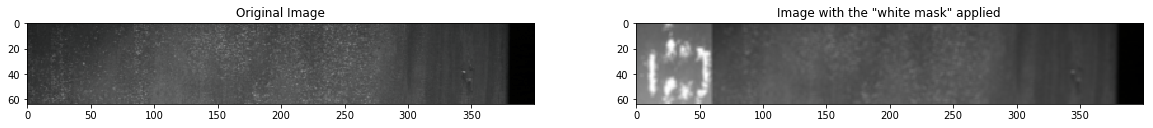

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
if not copied:
    original = X_val[n].clone()
    copied = True
X_val[n, :, :, :60] = X_masked[5, :, :, 130:190]
ax[0].imshow(np.transpose(original.numpy(), (1,2,0))*params['std'] + params['mean'])
ax[0].set_title('Original Image')
ax[1].imshow(cv2.blur(np.transpose(X_val[n].numpy(), (1,2,0))*params['std'] + params['mean'], (3, 3)))
ax[1].set_title('Image with the "white mask" applied')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


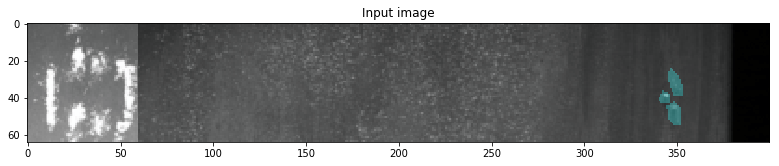

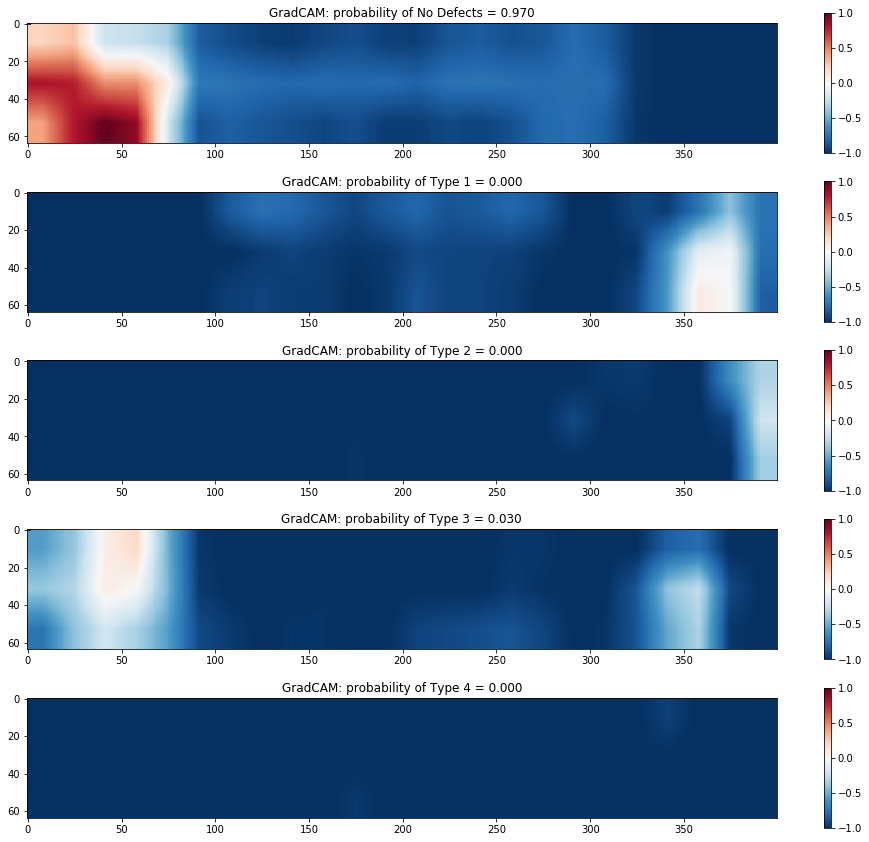

In [113]:
res = visualize_gradcam(n, module = net.classifier[1], out_type = 'relu', normalizer=True, color_normalizer=False, return_output=True)

In [123]:
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d